# Validating Likelihood Variance And Single Likelihood Weight Distribution

In this notebook we seek to characterize the noise that appears to accumulate in our learning process and manifests in poor quality posteriors. We narrow our attention to two cases. First, how the number of samples in each halo's likelihood integral impacts the variance of the total likelihood. Second, how the weight contributions of individual halos varies across hypersamples.

### Variance Sensitivity to Number of Importance Samples
We take the hyperparameter from the center of the prior distribution (mean of gaussians - [10.709, 0.35899999999999999, 1.1000000000000001, 0.155]) and compute the total likelihood under a number of different random seeds. This allows us to quantify the intrinsic variance in our process. Remember that the return value is the log-likelihood so even a little variance can lead to astronomical differences in weights. Since we plan to use on the order of 10,000 samples we hope to achieve a log-likelihood variance < 2 (so standard deviation of multiplicative weight change is factor of 4 or so).  

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib import rc
rc('text', usetex=True)

In [2]:
!head -n 5 likelihoodvariancetest.txt

10.709 0.35899999999999999 1.1000000000000001 0.155 -980684.27620546962
10.709 0.35899999999999999 1.1000000000000001 0.155 -980704.15572621697
10.709 0.35899999999999999 1.1000000000000001 0.155 -980674.76044038776
10.709 0.35899999999999999 1.1000000000000001 0.155 -980738.03466439061
10.709 0.35899999999999999 1.1000000000000001 0.155 -980749.11271341972


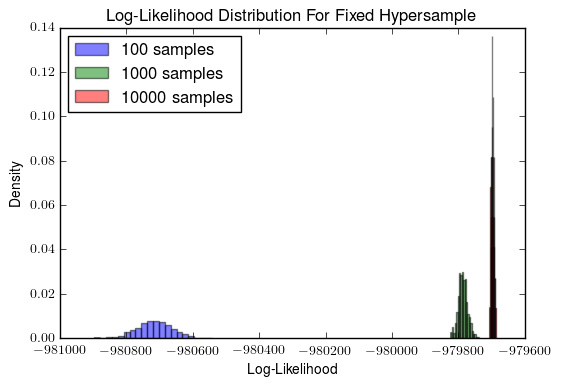

In [3]:
multi = np.loadtxt('likelihoodvariancetest.txt')
multi1000 = np.loadtxt('likelihoodvariancetest1000samples.txt')
multi10000 = np.loadtxt('likelihoodvariancetest10000samples.txt')
plt.title('Log-Likelihood Distribution For Fixed Hypersample')
plt.ylabel('Density')
plt.xlabel('Log-Likelihood')
plt.hist(multi[:,4], bins=20, normed=True, alpha=0.5, label='100 samples')
plt.hist(multi1000[:,4], bins=20, normed=True, alpha=0.5, label='1000 samples')
plt.hist(multi10000[:,4], bins=20, normed=True, alpha=0.5, label='10000 samples')
plt.legend(loc=2);

And here we have the standard deviations

In [4]:
print np.std(multi[:,4])
print np.std(multi1000[:,4])
print np.std(multi10000[:,4])

51.0639314938
13.849253536
3.94516995803


If we maintain our key assumption from the [Quantifying Scaling Accuracy notebook](QuantifyingScalingAccuracy1_20170623.ipynb), that the single log-likelihood integrals are independent and identically distributed gaussians. Then with 100 samples, the mean and variance are -8.46 and 0.06 respectively. Importance sampling is precise.

In [12]:
print 51.0639314938 / len(multi)
print np.mean(multi[:,4]) / 115919

0.0638299143672
-8.46035740056


### Single Likelihood Weights
In this experiment we take 4 hypersamples and collect the weights for the single likelihood corresponding to each halo (the sum of these single log-likelihoods is the total log-likelihood).

In [5]:
single = np.zeros((115919,4))
i = j = 0
with open('singleintegralweightvariancetest.txt', 'r') as f:
    for line in f:
        if 'likelihood' in line:
            j += 1
            i = 0
        else:
            single[i,j] = float(line)
            i += 1
f.close()

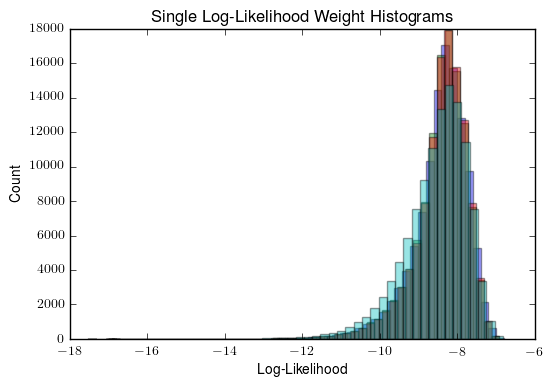

In [6]:
plt.hist(single[:,0], bins=50, alpha=0.4, label='l1')
plt.hist(single[:,1], bins=50, alpha=0.4, label='l2')
plt.hist(single[:,2], bins=50, alpha=0.4, label='l3')
plt.hist(single[:,3], bins=50, alpha=0.4, label='l4');
plt.title('Single Log-Likelihood Weight Histograms')
plt.ylabel('Count')
plt.xlabel('Log-Likelihood');

These look very similar. A natural next thing to check is the correlation between the weight sequences. We see extremely high correlation.

In [7]:
np.corrcoef(single.transpose())

array([[ 1.        ,  0.96855869,  0.96528591,  0.96110532],
       [ 0.96855869,  1.        ,  0.99907238,  0.8974694 ],
       [ 0.96528591,  0.99907238,  1.        ,  0.8904716 ],
       [ 0.96110532,  0.8974694 ,  0.8904716 ,  1.        ]])

# Discussion

In the previous notebooks we confirmed the presence of two failure modes. This notebook provides an explanation for each, along with other far reaching conclusions.

- **Failure Mode 1:** The posterior is not accurate, precise, or meaningful. **Explanation:** There is significant intrinsic variance in the likelihood computation which leads to an astronomically noisy posterior, which cannot be expected to produce meaningful results.

- **Failure Mode 2:** The weight discrepancies are enormous and hence we end up with one sample dominating the inference. **Partial Explanation:** The large discrepancies in weights is largely accounted for by the intrinsic variance in the computation.

- **Hypothesis Proven False:** "There are outlier single integral log-likelihoods that lead to the sporadic posterior." The [Single Likelihood Weights Section](#Single-Likelihood-Weights) shows that the single log-likelihood weights are fairly uniform and have highly correlation across hypersamples. Hence, specific halos with outlier integrals are not the primary cause of the sporadic posterior.

- The log-likelihood distributions show that as the number of samples is increased the likelihood increases. Increasing the number of samples by a factor of 10 increases the total likelihood by a factor of 0.001. This is not cause for too much concern or further analysis because this effect is very weak and a reasonable explanation exists. The larger number of samples makes it less likely that we have poorly covered the high weight single likelihood region. As the number of samples increases we tend to see an increase in likelihood because we are getting more resolution on the high weight region of the individual integrals. A sanity check we could perform would be to confirm that the shifting is consistent across hypersamples and hence will not significantly change a normalized posterior.

- Hyperposterior precision is primarily a function of the number of single integral samples and number of hypersamples. Next we run with even more samples and see if we can resolve the posterior.